In [13]:
from grid_up import *

## Exemple de cases numérique

In [14]:
class DataCreator_example(GridUp_testable):

    def __init__(self,power):
        self.power=power

    def generate_XY(self, batch_size) -> tuple:
        X=tf.random.uniform([batch_size,1])
        Y=tf.math.pow(X,self.power)
        return X,Y

    def loss(self, Y_true, Y_pred) -> tf.Tensor:
        return tf.reduce_mean(tf.square(Y_true-Y_pred))

    def scores(self, Y_true, Y_pred) -> tuple or float:
        return self.loss(Y_true, Y_pred).numpy()


class SimpleModel(tf.keras.Model):
    def __init__(self,width,nb_layers):
        super().__init__()

        self.lays=[tf.keras.layers.Dense(width,activation="relu") for _ in range(nb_layers)]
        self.final=tf.keras.layers.Dense(1)

    def call(self,X):
        for lay in self.lays:
            X=lay(X)
        return self.final(X)


def test_numeric_cases():
    powers_train=[2,4]
    powers_test=[1,2,3,4,5]

    creator_train={po:DataCreator_example(po) for po in powers_train}
    creator_test= {po:DataCreator_example(po) for po in powers_test}

    testor=GridUp(
        SimpleModel,
        creator_train,
        creator_test,
        fixed_params={"width":10,"nb_layers":3},
        varying_params={"width":[5,10,20],"nb_layers":[1,2,3,4]},
        minutes=0.05,
        verbose=True
    )

    res=testor.test_changing_param("width")
    return res

res_num=test_numeric_cases()

test le paramètre width avec les valeurs [5, 10, 20]
key=width, val=5
↘5.3e-02↘4.7e-02↘2.8e-02↘1.5e-02↘1.4e-02↘1.3e-02↘1.1e-02↘1.1e-02↘9.2e-03↘7.7e-03↘7.4e-03↘7.1e-03↘6.9e-03↘6.2e-03↘6.2e-03↘6.2e-03
 nb epochs:372 during 0.05 minutes
losses_test {1: 0.058434796, 2: 0.007898852, 3: 0.007731978, 4: 0.016011566, 5: 0.02546443}
key=width, val=10
↘8.7e-02↘6.6e-02↘6.3e-02↘4.6e-02↘4.3e-02↘3.7e-02↘3.5e-02↘2.5e-02↘1.1e-02↘1.1e-02↘1.1e-02↘1.0e-02↘9.2e-03↘9.1e-03↘8.1e-03↘7.6e-03↘7.0e-03↘6.8e-03↘6.8e-03↘5.0e-03↘4.5e-03↘4.4e-03↘4.3e-03↘4.2e-03↘4.0e-03↘4.0e-03↘3.8e-03↘3.7e-03↘3.1e-03
 nb epochs:356 during 0.05 minutes
losses_test {1: 0.06564778, 2: 0.0067161033, 3: 0.0024946523, 4: 0.009133703, 5: 0.019248653}
key=width, val=20
↘8.6e-02↘3.2e-02↘2.6e-02↘1.5e-02↘1.1e-02↘1.1e-02↘1.0e-02↘8.0e-03↘6.9e-03↘6.6e-03↘6.4e-03↘6.1e-03↘5.8e-03↘5.5e-03↘5.4e-03↘4.5e-03↘4.2e-03↘3.9e-03↘3.8e-03↘3.4e-03↘3.2e-03↘3.1e-03↘3.0e-03
 nb epochs:325 during 0.05 minutes
losses_test {1: 0.069386095, 2: 0.006805288, 3: 0.001086

In [15]:
res_num

{5: {1: 0.058434796,
  2: 0.007898852,
  3: 0.007731978,
  4: 0.016011566,
  5: 0.02546443},
 10: {1: 0.06564778,
  2: 0.0067161033,
  3: 0.0024946523,
  4: 0.009133703,
  5: 0.019248653},
 20: {1: 0.069386095,
  2: 0.006805288,
  3: 0.001086903,
  4: 0.007265569,
  5: 0.015326673}}

In [36]:
def plot_result(res,key,train_cases):
    """
    res: param-> (case->score)
    """


    dico=list(res.values())[0]
    cases=list(dico.keys())
    cases_are_str=isinstance(cases[0],str)

    cases_dico=None
    train_cases_are_str=isinstance(train_cases[0],str)
    if cases_are_str!=train_cases_are_str:
        raise Exception("test and train cases are not of same type (str or scalar)")


    if cases_are_str:
        cases_num=range(len(cases))
        cases_str=cases
        cases_dico={k:v for k,v in zip(cases_str,cases_num)}
    else:
        cases_num=cases
        cases_str=cases

    fig,ax=plt.subplots(figsize=(5,5))

    for param,dico in res.items():
        ax.plot(cases_num,dico.values(),".-",label=str(param))


    for x in train_cases:
        if cases_are_str:
            num_val=cases_dico.get(x)
            if num_val is not None:
                ax.axvline(x=num_val,linestyle=":")
            else:
                print(f"warning: the train-case '{x}' cannot be represented because it is a string that not belongs to the test-cases")
        else:
            ax.axvline(x=x,linestyle=":")

    ax.set_title("data_case->loss by "+str(key))
    ax.set_yscale("log")
    ax.set_xticks(cases_num)
    ax.set_xticklabels(cases_str)
    ax.set_xlabel("data cases")
    ax.set_ylabel("loss")
    ax.legend()
    plt.show()

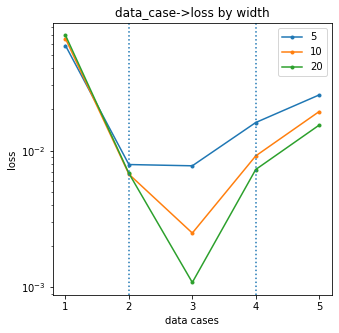

In [37]:
plot_result(res_num,"width",[2,4])

## Exemple de cases string

In [24]:
class DataCreator_string(GridUp_testable):

    def __init__(self, func_str):
        self.func=eval(func_str)

    def generate_XY(self, batch_size) -> tuple:
        X = tf.random.uniform([batch_size, 1])

        Y = self.func(X)
        return X, Y

    def loss(self, Y_true, Y_pred) -> tf.Tensor:
        return tf.reduce_mean(tf.square(Y_true - Y_pred))

    def scores(self, Y_true, Y_pred) -> tuple or float:
        return self.loss(Y_true, Y_pred).numpy()


def test_numeric_cases():

    powers_train = ["tf.exp","tf.sin"]
    powers_test = ["tf.exp","tf.sin","tf.square","tf.cos"]

    creator_train = {po: DataCreator_string(po) for po in powers_train}
    creator_test = {po: DataCreator_string(po) for po in powers_test}

    testor = GridUp(SimpleModel, creator_train, creator_test, fixed_params={"width": 10, "nb_layers": 3},
        varying_params={"width": [5, 10, 20], "nb_layers": [1, 2, 3, 4]}, minutes=0.05, )

    return testor.test_changing_param("width")
res_string=test_numeric_cases()

test le paramètre width avec les valeurs [5, 10, 20]


In [25]:
res_string

{5: {'tf.exp': 1.6763041,
  'tf.sin': 0.0028013175,
  'tf.square': 0.03284424,
  'tf.cos': 0.25698364},
 10: {'tf.exp': 1.7287178,
  'tf.sin': 0.025886843,
  'tf.square': 0.0616419,
  'tf.cos': 0.19732563},
 20: {'tf.exp': 1.6142673,
  'tf.sin': 0.013372128,
  'tf.square': 0.057944395,
  'tf.cos': 0.19293034}}

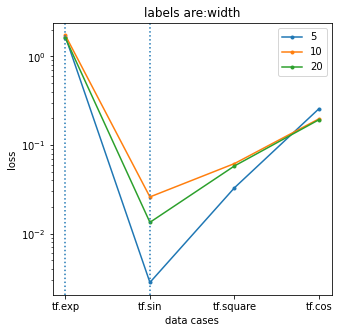

In [26]:
plot_result(res_string,"width",["tf.exp","tf.sin"])

In [21]:
def inverse_dico(param_case_score):
    res={}
    for param,case_score in param_case_score.items():
        for case,score in case_score.items():
            line=res.get(case,{})
            line[param]=score
            res[case]=line
    return res

In [22]:
res_num

{5: {1: 0.058434796,
  2: 0.007898852,
  3: 0.007731978,
  4: 0.016011566,
  5: 0.02546443},
 10: {1: 0.06564778,
  2: 0.0067161033,
  3: 0.0024946523,
  4: 0.009133703,
  5: 0.019248653},
 20: {1: 0.069386095,
  2: 0.006805288,
  3: 0.001086903,
  4: 0.007265569,
  5: 0.015326673}}

In [23]:
inverse_dico(res_num)

{1: {5: 0.058434796, 10: 0.06564778, 20: 0.069386095},
 2: {5: 0.007898852, 10: 0.0067161033, 20: 0.006805288},
 3: {5: 0.007731978, 10: 0.0024946523, 20: 0.001086903},
 4: {5: 0.016011566, 10: 0.009133703, 20: 0.007265569},
 5: {5: 0.02546443, 10: 0.019248653, 20: 0.015326673}}

In [34]:
def plot_result_inversed(param_case_score,key,train_cases):

    case_param_score=inverse_dico(param_case_score)

    param_scores=list(case_param_score.values())[0]

    params=list(param_scores.keys())
    params_are_str=isinstance(params[0],str)

    if params_are_str:
        params_num=range(len(params))
        params_str=params
    else:
        params_num=params
        params_str=params

    fig,ax=plt.subplots(figsize=(5,5))

    train_cases=set(train_cases)

    for case,param_score in case_param_score.items():
        label=str(case)
        if case in train_cases:
            label+=" (trained)"
        ax.plot(params_num,param_score.values(),".-",label=label)

    ax.set_title(str(key)+"->loss by data_case")
    ax.set_yscale("log")
    ax.set_xticks(params_num)
    ax.set_xticklabels(params_str)
    ax.set_xlabel("model:"+str(key))
    ax.set_ylabel("loss")
    ax.legend()
    plt.show()

In [27]:
inverse_dico(res_string)

{'tf.exp': {5: 1.6763041, 10: 1.7287178, 20: 1.6142673},
 'tf.sin': {5: 0.0028013175, 10: 0.025886843, 20: 0.013372128},
 'tf.square': {5: 0.03284424, 10: 0.0616419, 20: 0.057944395},
 'tf.cos': {5: 0.25698364, 10: 0.19732563, 20: 0.19293034}}

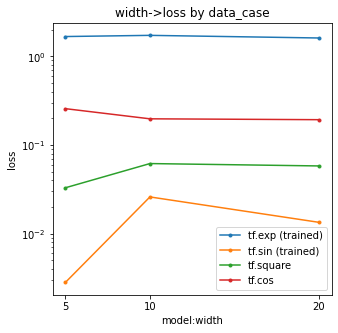

In [35]:
plot_result_inversed(res_string,"width",["tf.sin","tf.exp"])

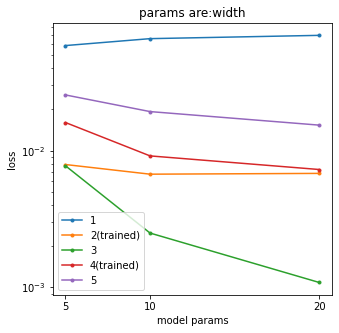

In [33]:
plot_result_inversed(res_num,"width",[2,4])
